# Analysis in Finding LncRNA Biomarker to Predict Immunotherapy Response in Melanoma

In this analysis, we analyzed a set of 13 candidate lncRNAs for potential biomarker to predict immunotherapy response in the TCGA Melanoma dataset. The 13 lncRNAs were obtained from [1], and they are SPRY4-IT1, BANCR, HOTAIR, MALAT1, UCA1, CASC15, ANRIL, RMEL3, SNHG5, SLNCR1, SAMMSON, LLME23, GAS5.

Clinical data from TCGA Melanoma were downloaded, which contains response data from patients who had immunotherapy treatment. The immunotherapy response ranges from "Clinical Progressive Disease", "Stable Disease", "Partial Response", "Complete Response".

By analyzing the correlation between the candidate lncRNA expression data and the immunotherapy response, we can identify potential lncRNA biomarker to predict immunotherapy response in melanoma.

**References**:

[1]: Hulstaert, E., Brochez, L., Volders, P. J., Vandesompele, J., & Mestdagh, P. (2017). Long non-coding RNAs in cutaneous melanoma: clinical perspectives. Oncotarget, 8(26), 43470.
Chicago	

In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import sklearn.linear_model
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC, LinearSVC
from sklearn.semi_supervised import label_propagation

# Import miTranscriptome Data (Deprecated)

In [ ]:
# lncrna_exp = pd.read_table("../data/raw/MiTranscriptome-SKCM_lncRNA_exp/mitranscriptome.expr.fpkm.tsv", delimiter="\t")

In [130]:
# lncrna_exp.index = lncrna_exp["transcript_id"]
# lncrna_exp = lncrna_exp.iloc[1:,:]
# lncrna_exp = lncrna_exp.T
lncrna_exp

,Gene_ID,SKCM-Tumor-TCGA-D3-A1Q1,SKCM-Tumor-TCGA-D3-A1Q3,SKCM-Tumor-TCGA-D3-A1Q4,SKCM-Tumor-TCGA-D3-A1Q5,SKCM-Tumor-TCGA-D3-A1Q6,SKCM-Tumor-TCGA-D3-A1Q7,SKCM-Tumor-TCGA-D3-A1Q8,SKCM-Tumor-TCGA-D3-A1Q9,SKCM-Tumor-TCGA-D3-A1QA,...,SKCM-Tumor-TCGA-GF-A3OT,SKCM-Tumor-TCGA-GN-A261,SKCM-Tumor-TCGA-GN-A262,SKCM-Tumor-TCGA-GN-A264,SKCM-Tumor-TCGA-GN-A265,SKCM-Tumor-TCGA-GN-A266,SKCM-Tumor-TCGA-GN-A267,SKCM-Tumor-TCGA-GN-A268,SKCM-Tumor-TCGA-GN-A26A,SKCM-Tumor-TCGA-GN-A26D
0,ENSG00000005206.12,0.221485,0.301805,0.390620,1.380212,0.108369,0.568456,0.317182,0.049637,0.361728,...,0.310220,0.704263,0.918968,0.407143,0.351461,0.881316,1.137700,0.809325,0.480373,0.318671
1,ENSG00000031544.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035605,0.000000,0.000000,...,0.017139,0.030989,0.000000,0.015993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSG00000083622.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.014868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000088970.11,0.135885,0.053352,0.091178,0.264219,0.126814,0.068246,0.080199,0.038024,0.116305,...,0.000323,0.403619,0.145616,0.174845,0.077805,0.117024,0.045492,0.023763,0.030293,0.105355
4,ENSG00000099869.6,0.000000,0.000000,0.021028,0.000000,0.000000,0.000000,0.021514,0.000000,0.000000,...,0.041424,0.509890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030828,0.000000
5,ENSG00000100181.17,0.066190,0.063315,2.161100,4.791449,0.470844,0.115449,0.131042,0.014968,0.022503,...,0.093135,0.561728,0.012476,0.073439,0.154906,0.184371,0.031762,0.012495,0.158829,0.018362
6,ENSG00000104691.10,0.157255,0.170210,0.432922,0.526319,0.422747,0.167906,0.218024,0.053316,0.267351,...,0.130371,0.115324,0.379136,0.153083,0.073951,0.124153,0.478343,0.233748,0.664933,0.364459
7,ENSG00000110347.7,0.000000,0.015005,0.020663,0.000000,0.000000,0.113145,0.000000,0.038638,0.000000,...,0.000000,0.000000,0.000000,0.018992,0.000000,0.203660,0.000000,0.000000,0.302928,0.000000
8,ENSG00000115934.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.004087,0.000000,0.003402,0.000000,...,0.000000,0.012619,0.003913,0.000000,0.000000,0.000000,0.000000,0.000000,0.019694,0.000000
9,ENSG00000117242.7,0.024147,0.089057,0.050449,0.356765,0.081990,0.057307,0.048321,0.072257,0.040198,...,0.038062,0.354938,0.205212,0.134669,0.038843,0.255237,0.000000,0.038885,0.018884,0.000000


In [46]:
library_info = pd.read_table("../data/raw/MiTranscriptome-SKCM_lncRNA_exp/library_info.txt", delimiter="\t")
library_info = library_info[library_info["tcga_cancer_type"] == "SKCM"]
library_info["tcga_legacy_sample_id"] = library_info["tcga_legacy_sample_id"].str.slice(0,12)
print list(library_info.columns)
# library_info.head()
print library_info.shape
# library_info[library_info["study_id"] == "uc010roh.3"]
# library_info["sample_type"].unique()
library_info

['library_id', 'study_id', 'cohort_id', 'species', 'library_protocol', 'fragment_layout', 'cancer_progression', 'cancer_type', 'harvest_site', 'sample_type', 'tcga_cancer_type', 'tcga_legacy_sample_id', 'total_fragments', 'frag_size_mean', 'frag_size_stdev', 'total_aligned_reads', 'mean_read_length', 'aligned_bases', 'pct_mrna_bases', 'pct_intronic_bases', 'pct_intergenic_bases']
(265, 21)


,library_id,study_id,cohort_id,species,library_protocol,fragment_layout,cancer_progression,cancer_type,harvest_site,sample_type,...,tcga_legacy_sample_id,total_fragments,frag_size_mean,frag_size_stdev,total_aligned_reads,mean_read_length,aligned_bases,pct_mrna_bases,pct_intronic_bases,pct_intergenic_bases
5148,aaea9670-416a-4293-af12-8bfeb47b0150,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-GN-A263,59610748,176,52,90405894,48,4338917038,0.906365,0.040369,0.053261
5149,73b2e2ac-aafd-40e7-8759-ffa226f04a3b,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-BF-A1PX,87929125,189,55,148097529,48,7108119385,0.920194,0.020730,0.059075
5150,ca667c68-e9fb-4003-8639-5fa1d00a7a95,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-BF-A3DM,74273837,190,57,138166617,48,6631431000,0.929954,0.024018,0.046026
5151,132fbce2-00f3-4ae7-ba18-03bd55529d5a,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-EB-A1NK,105410626,188,54,186153542,48,8934650872,0.941784,0.021855,0.036361
5152,5798deb1-2248-474f-b0cd-20c966128d9d,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-GF-A2C7,86979753,184,57,151531306,48,7272806761,0.901976,0.048794,0.049228
5153,376614bb-480e-4a7f-9539-da6ce053988a,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-ER-A194,69794615,170,48,95875022,48,4601696158,0.937451,0.023451,0.039090
5154,cc0cd3e6-a133-4796-ab06-5adb905d5184,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-EB-A24C,90679165,178,55,164459829,48,7893331953,0.909517,0.037165,0.053317
5155,9ff4d588-da73-4e26-975d-2b098fe74984,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-BF-A1PU,85539875,181,55,154298231,48,7405681039,0.933139,0.022900,0.043960
5156,27bf4227-d8a9-4048-af7e-01c6d5d0e777,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-BF-A1PZ,85121939,173,55,155469327,48,7461917475,0.928395,0.029559,0.042046
5157,8B4C42A9-7D09-4989-A0E2-43ABB6097137,phs000178,skin,human,polya_transcriptome,paired,cancer,melanoma,primary_tumor,tissue,...,TCGA-EB-A3XC,47561588,192,60,89457336,48,4293611333,0.927555,0.028934,0.043510


In [8]:
lncrna_id = pd.read_csv("../data/raw/MiTranscriptome-SKCM_lncRNA_exp/SKCM_lncrna_id.csv")
lncrna_dict = pd.Series(lncrna_id.Name.values, index=lncrna_id["Transcript ID"]).to_dict()
lncrna_exp.replace({"transcript_id": lncrna_dict}, inplace=True)

{'T054686': 'SBF2-AS1.5',
 'T054687': 'SBF2-AS1.6',
 'T232277': 'KCCAT194',
 'T190264': 'KCCAT636',
 'T148754': 'PRCAT315',
 'T314979': 'MEAT52.2',
 'T141422': 'CAT1901.2',
 'T181493': 'AMAT90',
 'T341075': 'CVAT21',
 'T275568': 'AMAT84',
 'T135202': 'LSCAT282',
 'T019989': 'CAT107',
 'T367646': 'THCAT601',
 'T307419': 'CAT833',
 'T188502': 'CAT236',
 'T146596': 'AMAT106',
 'T146597': 'CAT1928',
 'T203739': 'GBAT21',
 'T231786': 'KHCAT171',
 'T107549': 'CAT1691',
 'T252716': 'CAT458',
 'T165229': 'BRCAT57',
 'T299288': 'KCCAT112',
 'T193444': 'LINC00152.1',
 'T028139': 'PCAT6',
 'T074554': 'CAT1479',
 'T148999': 'KCCAT596',
 'T045632': 'NUTM2A-AS1.2',
 'T193443': 'LINC00152.2',
 'T252882': 'LACAT207',
 'T073015': 'CAT1466.2',
 'T020194': 'HRAT4',
 'T205083': 'LACAT88',
 'T327855': 'CAT950',
 'T218701': 'BRCAT322',
 'T150288': 'CAT1950.1',
 'T044850': 'CAT1283',
 'T317967': 'LVCAT6',
 'T073019': 'CAT1466.3',
 'T177396': 'CAT2113.1',
 'T205779': 'CFLAR-AS1.1',
 'T232309': 'CAT2238',
 'T0

In [22]:
lncrna_exp = lncrna_exp.filter(items=["transcript_id",]+list(library_info["library_id"]))

In [31]:
lncrna_exp.index = lncrna_exp["transcript_id"]
lncrna_exp = lncrna_exp.drop("transcript_id", axis=1).T
lncrna_exp['bcr_patient_barcode'] = lncrna_exp.index
lncrna_exp.reset_index(inplace=True)

In [52]:
lncrna_exp.replace({"bcr_patient_barcode": pd.Series(library_info.tcga_legacy_sample_id.values, index=library_info.library_id).to_dict()}, 
                  inplace=True)

In [421]:
lncrna_exp

,Gene_ID,SKCM-Tumor-TCGA-D3-A1Q1,SKCM-Tumor-TCGA-D3-A1Q3,SKCM-Tumor-TCGA-D3-A1Q4,SKCM-Tumor-TCGA-D3-A1Q5,SKCM-Tumor-TCGA-D3-A1Q6,SKCM-Tumor-TCGA-D3-A1Q7,SKCM-Tumor-TCGA-D3-A1Q8,SKCM-Tumor-TCGA-D3-A1Q9,SKCM-Tumor-TCGA-D3-A1QA,...,SKCM-Tumor-TCGA-GF-A3OT,SKCM-Tumor-TCGA-GN-A261,SKCM-Tumor-TCGA-GN-A262,SKCM-Tumor-TCGA-GN-A264,SKCM-Tumor-TCGA-GN-A265,SKCM-Tumor-TCGA-GN-A266,SKCM-Tumor-TCGA-GN-A267,SKCM-Tumor-TCGA-GN-A268,SKCM-Tumor-TCGA-GN-A26A,SKCM-Tumor-TCGA-GN-A26D
Gene_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000005206,ENSG00000005206,0.221485,0.301805,0.390620,1.380212,0.108369,0.568456,0.317182,0.049637,0.361728,...,0.310220,0.704263,0.918968,0.407143,0.351461,0.881316,1.137700,0.809325,0.480373,0.318671
ENSG00000031544,ENSG00000031544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035605,0.000000,0.000000,...,0.017139,0.030989,0.000000,0.015993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000083622,ENSG00000083622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.014868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000088970,ENSG00000088970,0.135885,0.053352,0.091178,0.264219,0.126814,0.068246,0.080199,0.038024,0.116305,...,0.000323,0.403619,0.145616,0.174845,0.077805,0.117024,0.045492,0.023763,0.030293,0.105355
IGF2-AS,IGF2-AS,0.000000,0.000000,0.021028,0.000000,0.000000,0.000000,0.021514,0.000000,0.000000,...,0.041424,0.509890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030828,0.000000
ENSG00000100181,ENSG00000100181,0.066190,0.063315,2.161100,4.791449,0.470844,0.115449,0.131042,0.014968,0.022503,...,0.093135,0.561728,0.012476,0.073439,0.154906,0.184371,0.031762,0.012495,0.158829,0.018362
ENSG00000104691,ENSG00000104691,0.157255,0.170210,0.432922,0.526319,0.422747,0.167906,0.218024,0.053316,0.267351,...,0.130371,0.115324,0.379136,0.153083,0.073951,0.124153,0.478343,0.233748,0.664933,0.364459
ENSG00000110347,ENSG00000110347,0.000000,0.015005,0.020663,0.000000,0.000000,0.113145,0.000000,0.038638,0.000000,...,0.000000,0.000000,0.000000,0.018992,0.000000,0.203660,0.000000,0.000000,0.302928,0.000000
ENSG00000115934,ENSG00000115934,0.000000,0.000000,0.000000,0.000000,0.000000,0.004087,0.000000,0.003402,0.000000,...,0.000000,0.012619,0.003913,0.000000,0.000000,0.000000,0.000000,0.000000,0.019694,0.000000


# Import lncRNA ENSEMBL nonemclature (TANRIC dataset)

In [52]:
lncrna_exp = pd.read_table("../data/raw/TANRIC-SKCM-lncRNA_exp/TCGA-SKCM-rnaexpr.tsv", delimiter="\t")

In [53]:
lncrna_names = pd.read_table("../data/external/HGNC_RNA_long_non-coding.txt", delimiter="\t")

In [54]:
lncrna_dict = pd.Series(lncrna_names.symbol.values, index=lncrna_names.ensembl_gene_id).to_dict()
lncrna_dict["ENSG00000274721"] = "SPRY4-IT1" # Chr5:142317620-142318322
lncrna_dict["ENSG00000240498"] = "ANRIL" # Chr9:21994791-22121097 (selected 9:21994791-22044790 because 50kb max)
# # lncrna_dict[""] = "RMEL3" Exon1 (Chr5:56690887-56691005)
lncrna_dict["ENSG00000203875"] = "SNHG5" # Chr6:85677007-85678733
# # lncrna_dict[""] = "SLNCR1" # Chr17:72403322-72592804 (selected Chr17:72403322-72453321 because 50kb max)
lncrna_dict["ENSG00000116560"] = "LLME23" # Chr6:165533548-165533786
# "BANCR" # Chr9:69296682-69,306977 

In [55]:
# Replacing ENSG Gene ID to the lncRNA symbol name
lncrna_exp['Gene_ID'] = lncrna_exp['Gene_ID'].str.replace("[.].*", "")
lncrna_exp.replace({"Gene_ID": lncrna_dict}, inplace=True)

# Subsetting lncRNA exp to only key lncRNA's

In [56]:
melanoma_lcrna_exp = lncrna_exp

In [57]:
melanoma_lcrna_exp.index = melanoma_lcrna_exp['Gene_ID']
melanoma_lcrna_exp = melanoma_lcrna_exp.T.iloc[1:,:]

# Filter only lncRNA expressions in the 13 lncRNA biomarkers


In [58]:
melanoma_lncrnas = ["SPRY4-IT1", "BANCR", "HOTAIR", "MALAT1", "UCA1", "CASC15", "ANRIL", "RMEL3", "SNHG5", "SLNCR1", "SAMMSON", "LLME23", "GAS5"]
melanoma_lcrna_exp = melanoma_lcrna_exp.filter(items=melanoma_lncrnas, axis=1)

In [59]:
# Log 2 transform lncRNA expression data
def lncRNA_exp_transform(x):
    if x == 0:
#         return -16.610
        return np.log2(x+1)
    else:
        return np.log2(x+1)

def gene_exp_transform(x):
    return np.log2(x+1)
melanoma_lcrna_exp = melanoma_lcrna_exp.applymap(lncRNA_exp_transform)

In [60]:
melanoma_lcrna_exp["bcr_patient_barcode"] = melanoma_lcrna_exp.index
print(len(melanoma_lcrna_exp["bcr_patient_barcode"].unique()))
melanoma_lcrna_exp

226


Gene_ID,HOTAIR,MALAT1,UCA1,CASC15,ANRIL,SNHG5,SAMMSON,GAS5,bcr_patient_barcode
SKCM-Tumor-TCGA-D3-A1Q1,0.045786,1.623169,0.000000,2.242216,0.041389,5.909721,0.526308,6.373355,SKCM-Tumor-TCGA-D3-A1Q1
SKCM-Tumor-TCGA-D3-A1Q3,0.370566,3.397071,0.000000,1.798074,0.350604,4.923508,0.219065,3.917426,SKCM-Tumor-TCGA-D3-A1Q3
SKCM-Tumor-TCGA-D3-A1Q4,0.788655,2.945070,0.000000,1.013218,0.278314,5.560120,1.183244,5.870914,SKCM-Tumor-TCGA-D3-A1Q4
SKCM-Tumor-TCGA-D3-A1Q5,2.792520,3.244967,0.012772,1.350535,0.000000,4.063053,0.481112,4.958710,SKCM-Tumor-TCGA-D3-A1Q5
SKCM-Tumor-TCGA-D3-A1Q6,1.305497,3.200828,0.805706,0.217885,0.270288,3.245418,0.671427,4.117370,SKCM-Tumor-TCGA-D3-A1Q6
SKCM-Tumor-TCGA-D3-A1Q7,1.613167,2.929319,0.000000,0.806374,0.583355,4.636425,0.715332,4.208355,SKCM-Tumor-TCGA-D3-A1Q7
SKCM-Tumor-TCGA-D3-A1Q8,1.202404,1.764110,0.000000,1.165896,0.007807,3.787902,0.385478,3.548623,SKCM-Tumor-TCGA-D3-A1Q8
SKCM-Tumor-TCGA-D3-A1Q9,0.024470,3.226222,0.020798,1.078149,0.042829,3.832738,2.951929,3.403670,SKCM-Tumor-TCGA-D3-A1Q9
SKCM-Tumor-TCGA-D3-A1QA,0.078734,1.954532,0.006307,1.162393,0.433921,5.097393,1.241145,5.972185,SKCM-Tumor-TCGA-D3-A1QA
SKCM-Tumor-TCGA-D3-A1QB,0.024698,1.331484,0.007181,1.265111,0.063520,3.928409,0.555594,4.034504,SKCM-Tumor-TCGA-D3-A1QB


# Adding exp of missing lncRNAs

In [61]:
# lncrna_exp = pd.read_table("../data/raw/TANRIC-SKCM-lncRNA_exp/lncRNA_exp_by_genomic_coordinate/ANRIL_log2exp_SKCM.tsv", delimiter="\t")
for fn in os.listdir('../data/raw/TANRIC-SKCM-lncRNA_exp/lncRNA_exp_by_genomic_coordinate/'):
    if len(str.split(fn, ".")) > 1 and str.split(fn, ".")[1] == "tsv":
        lncRNA_name = str.split(fn, "_")[0]
        missing_lncRNA_exp = pd.read_table("../data/raw/TANRIC-SKCM-lncRNA_exp/lncRNA_exp_by_genomic_coordinate/"+fn, delimiter="\t")
        print(lncRNA_name, missing_lncRNA_exp.shape)
        missing_lncRNA_exp["lncRNA_exp_log2"] = np.power(2, missing_lncRNA_exp["lncRNA_exp_log2"])
        missing_lncRNA_exp["lncRNA_exp_log2"] = missing_lncRNA_exp["lncRNA_exp_log2"] - np.min(missing_lncRNA_exp["lncRNA_exp_log2"])
        missing_lncRNA_exp["lncRNA_exp_log2"] = missing_lncRNA_exp["lncRNA_exp_log2"].apply(lncRNA_exp_transform)
#         print(missing_lncRNA_exp)
        missing_lncRNA_exp.rename(columns={"lncRNA_exp_log2": lncRNA_name}, inplace=True)
        melanoma_lcrna_exp = melanoma_lcrna_exp.merge(missing_lncRNA_exp.drop(["Cancer", "position_annotation"], axis=1), 
                                       how="outer", left_on="bcr_patient_barcode", right_on="SampleID", suffixes=('','_y'))

ANRIL (226, 4)
        Cancer  position_annotation                 SampleID  lncRNA_exp_log2
0    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q1         0.089278
1    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q3         0.351573
2    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q4         0.792465
3    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q5         0.054128
4    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q6         1.782467
5    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q7         0.314127
6    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q8         0.131352
7    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1Q9         0.256785
8    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1QA         1.134600
9    TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A1QB         0.280128
10   TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-TCGA-D3-A2J6         0.226368
11   TCGA-SKCM  9:21994791-22044790  SKCM-Tumor-T

In [62]:
# melanoma_lcrna_exp.drop([x for x in melanoma_lcrna_exp.columns if x.endswith('SampleID_y')], axis=1, inplace=True)
# melanoma_lcrna_exp.drop([x for x in melanoma_lcrna_exp.columns if x.endswith('SNHG5_y')], axis=1, inplace=True)
melanoma_lcrna_exp.drop([x for x in melanoma_lcrna_exp.columns if x.endswith('_y')], axis=1, inplace=True)

In [63]:
print (melanoma_lcrna_exp.columns)
melanoma_lcrna_exp

Index(['HOTAIR', 'MALAT1', 'UCA1', 'CASC15', 'ANRIL', 'SNHG5', 'SAMMSON',
       'GAS5', 'bcr_patient_barcode', 'SampleID', 'LLME23', 'RMEL3', 'SLNCR1',
       'SPRY4-IT1'],
      dtype='object')


,HOTAIR,MALAT1,UCA1,CASC15,ANRIL,SNHG5,SAMMSON,GAS5,bcr_patient_barcode,SampleID,LLME23,RMEL3,SLNCR1,SPRY4-IT1
0,0.045786,1.623169,0.000000,2.242216,0.041389,5.909721,0.526308,6.373355,SKCM-Tumor-TCGA-D3-A1Q1,SKCM-Tumor-TCGA-D3-A1Q1,0.000000,0.000000,0.030138,0.000000
1,0.370566,3.397071,0.000000,1.798074,0.350604,4.923508,0.219065,3.917426,SKCM-Tumor-TCGA-D3-A1Q3,SKCM-Tumor-TCGA-D3-A1Q3,0.095686,0.000000,0.028299,0.000000
2,0.788655,2.945070,0.000000,1.013218,0.278314,5.560120,1.183244,5.870914,SKCM-Tumor-TCGA-D3-A1Q4,SKCM-Tumor-TCGA-D3-A1Q4,0.000000,0.058918,0.299906,0.000000
3,2.792520,3.244967,0.012772,1.350535,0.000000,4.063053,0.481112,4.958710,SKCM-Tumor-TCGA-D3-A1Q5,SKCM-Tumor-TCGA-D3-A1Q5,0.000000,1.919055,0.504777,0.000000
4,1.305497,3.200828,0.805706,0.217885,0.270288,3.245418,0.671427,4.117370,SKCM-Tumor-TCGA-D3-A1Q6,SKCM-Tumor-TCGA-D3-A1Q6,0.018093,0.000000,0.014277,0.000000
5,1.613167,2.929319,0.000000,0.806374,0.583355,4.636425,0.715332,4.208355,SKCM-Tumor-TCGA-D3-A1Q7,SKCM-Tumor-TCGA-D3-A1Q7,0.000000,0.000000,0.290532,0.000000
6,1.202404,1.764110,0.000000,1.165896,0.007807,3.787902,0.385478,3.548623,SKCM-Tumor-TCGA-D3-A1Q8,SKCM-Tumor-TCGA-D3-A1Q8,0.000000,0.000000,0.536805,0.000000
7,0.024470,3.226222,0.020798,1.078149,0.042829,3.832738,2.951929,3.403670,SKCM-Tumor-TCGA-D3-A1Q9,SKCM-Tumor-TCGA-D3-A1Q9,0.000000,0.126390,0.055290,0.000000
8,0.078734,1.954532,0.006307,1.162393,0.433921,5.097393,1.241145,5.972185,SKCM-Tumor-TCGA-D3-A1QA,SKCM-Tumor-TCGA-D3-A1QA,0.003795,0.000000,0.023824,0.000000
9,0.024698,1.331484,0.007181,1.265111,0.063520,3.928409,0.555594,4.034504,SKCM-Tumor-TCGA-D3-A1QB,SKCM-Tumor-TCGA-D3-A1QB,0.000000,0.000000,0.019543,0.000000


In [64]:
melanoma_lcrna_exp["bcr_patient_barcode"] = melanoma_lcrna_exp["bcr_patient_barcode"].str.replace("SKCM-Tumor-", "")

In [65]:
# Missing lncRNAs
set(melanoma_lncrnas) - set(melanoma_lcrna_exp.columns.tolist())

{'BANCR'}

# Importing all TCGA SKCM patient's clinical data
## Doesn't necessary include all SKCM patients with lncRNA expressions profiled

In [75]:
skcm_clinical = pd.read_table("../data/processed/SKCM_clinical/clinical_SKCM_all.txt__nationwidechildrens.org_clinical_drug_skcm.txt", 
                             delimiter="\t")
skcm_clinical = skcm_clinical[['bcr_patient_barcode', 'pharmaceutical_therapy_type', 'treatment_best_response']].iloc[1:,:]
np.unique(skcm_clinical['treatment_best_response'])

array(['CDE_ID:2857291', 'Clinical Progressive Disease',
       'Complete Response', 'Partial Response', 'Stable Disease',
       '[Not Applicable]', '[Not Available]', '[Unknown]'], dtype=object)

In [76]:
skcm_clinical = skcm_clinical[skcm_clinical["pharmaceutical_therapy_type"] == "Immunotherapy"]
skcm_clinical.replace({"treatment_best_response":{"[Unknown]":-1, "[Not Available]":-1, "[Not Applicable]":-1}}, 
                      inplace=True)

skcm_clinical = skcm_clinical[skcm_clinical["treatment_best_response"].isin(['Clinical Progressive Disease', 
                                                                             'Complete Response', 
                                                                             'Partial Response', 
                                                                             'Stable Disease',
                                                                             'CDE_ID:2857291'])]

print (skcm_clinical["treatment_best_response"].value_counts())

Clinical Progressive Disease    20
Complete Response               12
Partial Response                 9
Stable Disease                   8
Name: treatment_best_response, dtype: int64


In [77]:
skcm_clinical

,bcr_patient_barcode,pharmaceutical_therapy_type,treatment_best_response
3,TCGA-D3-A1Q1,Immunotherapy,Clinical Progressive Disease
15,TCGA-D3-A2JP,Immunotherapy,Partial Response
19,TCGA-D3-A3MV,Immunotherapy,Clinical Progressive Disease
30,TCGA-D3-A8GB,Immunotherapy,Complete Response
32,TCGA-D3-A8GN,Immunotherapy,Complete Response
35,TCGA-DA-A3F2,Immunotherapy,Partial Response
37,TCGA-DA-A3F5,Immunotherapy,Stable Disease
62,TCGA-EB-A57M,Immunotherapy,Complete Response
69,TCGA-EB-A5KH,Immunotherapy,Complete Response
72,TCGA-EB-A5SH,Immunotherapy,Complete Response


# Merging lncRNA expression data to clinical data, select only samples with immunotherapy responses

In [78]:
melanoma_lcrna_immuno_exp = melanoma_lcrna_exp.merge(skcm_clinical, how="inner", 
                                                     left_on="bcr_patient_barcode", right_on="bcr_patient_barcode")

In [79]:
skcm_clinical["treatment_best_response"] = skcm_clinical.merge(melanoma_lcrna_immuno_exp[["bcr_patient_barcode", "treatment_best_response"]], 
                                                               how="left", 
                                                               left_on="bcr_patient_barcode", 
                                                               right_on="bcr_patient_barcode", 
                                                               suffixes=('_x', ''))["treatment_best_response"]
skcm_clinical

,bcr_patient_barcode,pharmaceutical_therapy_type,treatment_best_response
3,TCGA-D3-A1Q1,Immunotherapy,NaN
15,TCGA-D3-A2JP,Immunotherapy,Clinical Progressive Disease
19,TCGA-D3-A3MV,Immunotherapy,NaN
30,TCGA-D3-A8GB,Immunotherapy,NaN
32,TCGA-D3-A8GN,Immunotherapy,NaN
35,TCGA-DA-A3F2,Immunotherapy,NaN
37,TCGA-DA-A3F5,Immunotherapy,NaN
62,TCGA-EB-A57M,Immunotherapy,NaN
69,TCGA-EB-A5KH,Immunotherapy,NaN
72,TCGA-EB-A5SH,Immunotherapy,NaN


In [80]:
melanoma_lcrna_immuno_exp

,HOTAIR,MALAT1,UCA1,CASC15,ANRIL,SNHG5,SAMMSON,GAS5,bcr_patient_barcode,SampleID,LLME23,RMEL3,SLNCR1,SPRY4-IT1,pharmaceutical_therapy_type,treatment_best_response
0,0.045786,1.623169,0.000000,2.242216,0.041389,5.909721,0.526308,6.373355,TCGA-D3-A1Q1,SKCM-Tumor-TCGA-D3-A1Q1,0.000000,0.000000,0.030138,0.000000,Immunotherapy,Clinical Progressive Disease
1,0.077076,4.023821,0.000000,0.576406,0.365872,5.678011,0.503184,5.237496,TCGA-D3-A2JP,SKCM-Tumor-TCGA-D3-A2JP,0.032775,0.000000,0.012380,0.000000,Immunotherapy,Partial Response
2,0.912712,3.094637,0.013352,1.767870,0.341291,3.479556,2.160035,5.487785,TCGA-D3-A3MV,SKCM-Tumor-TCGA-D3-A3MV,0.031910,0.000000,0.011792,0.000000,Immunotherapy,Clinical Progressive Disease
3,0.033865,1.132158,0.000000,1.018009,0.039732,3.058709,0.340364,3.550797,TCGA-EE-A29C,SKCM-Tumor-TCGA-EE-A29C,0.000000,0.000000,0.104723,0.000000,Immunotherapy,Stable Disease
4,1.438499,2.408470,0.000000,1.560618,0.004791,5.295659,1.128106,5.606087,TCGA-EE-A2GS,SKCM-Tumor-TCGA-EE-A2GS,0.028572,0.129702,0.431196,0.000000,Immunotherapy,Clinical Progressive Disease
5,0.199129,2.966405,0.008589,0.847909,0.008799,4.524830,0.592157,4.995529,TCGA-EE-A2ML,SKCM-Tumor-TCGA-EE-A2ML,0.169247,0.080932,0.009909,0.014017,Immunotherapy,Clinical Progressive Disease
6,0.464930,4.430245,0.000000,0.081610,0.792343,5.524903,1.305313,6.744909,TCGA-EE-A3JI,SKCM-Tumor-TCGA-EE-A3JI,0.000000,0.005021,0.000562,0.020286,Immunotherapy,Clinical Progressive Disease
7,0.186805,2.745405,0.000000,1.433710,0.019769,3.209094,1.888804,3.953731,TCGA-ER-A19M,SKCM-Tumor-TCGA-ER-A19M,0.115077,2.127053,0.026157,0.000000,Immunotherapy,Clinical Progressive Disease
8,0.163824,2.594212,0.000000,0.646523,0.002167,4.927034,1.300358,5.129001,TCGA-FR-A3YN,SKCM-Tumor-TCGA-FR-A3YN,0.382899,0.000000,0.000485,0.000000,Immunotherapy,Complete Response
9,0.044782,0.408822,0.034270,0.196795,0.012896,4.775156,0.028358,4.072337,TCGA-FR-A3YO,SKCM-Tumor-TCGA-FR-A3YO,0.000000,0.000000,0.539940,0.000000,Immunotherapy,Stable Disease


In [73]:
# melanoma_lcrna_immuno_exp[melanoma_lcrna_immuno_exp["treatment_best_response"].notnull()]
melanoma_lcrna_immuno_exp.dropna(axis=1, inplace=True)
melanoma_lcrna_immuno_exp

,HOTAIR,MALAT1,UCA1,CASC15,ANRIL,SNHG5,SAMMSON,GAS5,bcr_patient_barcode,SampleID,LLME23,RMEL3,SLNCR1,SPRY4-IT1,pharmaceutical_therapy_type,treatment_best_response
0,0.045786,1.623169,0.000000,2.242216,0.041389,5.909721,0.526308,6.373355,TCGA-D3-A1Q1,SKCM-Tumor-TCGA-D3-A1Q1,0.000000,0.000000,0.030138,0.000000,Immunotherapy,Clinical Progressive Disease
1,1.305497,3.200828,0.805706,0.217885,0.270288,3.245418,0.671427,4.117370,TCGA-D3-A1Q6,SKCM-Tumor-TCGA-D3-A1Q6,0.018093,0.000000,0.014277,0.000000,Immunotherapy,-1
2,0.260680,3.189068,0.006859,0.668553,0.378902,5.312426,0.589148,5.505603,TCGA-D3-A2JH,SKCM-Tumor-TCGA-D3-A2JH,0.000000,0.000000,0.080021,0.000000,Immunotherapy,-1
3,0.008316,3.982021,0.000000,0.081966,0.053334,3.464596,0.128167,5.625648,TCGA-D3-A2JN,SKCM-Tumor-TCGA-D3-A2JN,0.000000,1.732490,0.061811,0.000000,Immunotherapy,-1
4,0.077076,4.023821,0.000000,0.576406,0.365872,5.678011,0.503184,5.237496,TCGA-D3-A2JP,SKCM-Tumor-TCGA-D3-A2JP,0.032775,0.000000,0.012380,0.000000,Immunotherapy,Partial Response
5,0.019683,1.287995,0.000000,0.555154,0.062460,5.268837,0.721800,4.464043,TCGA-D3-A3C1,SKCM-Tumor-TCGA-D3-A3C1,0.000000,0.000000,0.019576,0.000000,Immunotherapy,-1
6,0.398843,2.711787,0.000000,0.516060,0.020436,4.259681,0.132735,3.284649,TCGA-D3-A3C7,SKCM-Tumor-TCGA-D3-A3C7,0.000000,0.000000,0.050026,0.000000,Immunotherapy,-1
7,0.912712,3.094637,0.013352,1.767870,0.341291,3.479556,2.160035,5.487785,TCGA-D3-A3MV,SKCM-Tumor-TCGA-D3-A3MV,0.031910,0.000000,0.011792,0.000000,Immunotherapy,Clinical Progressive Disease
8,0.000000,1.283474,0.000000,1.480431,0.072499,4.540374,0.732825,4.762051,TCGA-D9-A148,SKCM-Tumor-TCGA-D9-A148,0.000000,0.725807,0.664521,0.000000,Immunotherapy,-1
9,0.064279,2.862432,0.023665,1.554435,0.265237,4.115823,0.522455,4.464198,TCGA-DA-A1I1,SKCM-Tumor-TCGA-DA-A1I1,0.037742,0.074838,0.051753,0.000000,Immunotherapy,-1


# Importing TCGA Gene Expression data (Filter Immune Genes from TCIA)

In [63]:
skcm_gene_exp = pd.read_table("../data/processed/SKCM__geneExp_normalized.txt", delimiter="\t")
skcm_gene_exp.drop(["EntrezID"], axis=1, inplace=True)
skcm_gene_exp = skcm_gene_exp[skcm_gene_exp["GeneSymbol"] != "?"]
skcm_gene_exp.index = skcm_gene_exp['GeneSymbol']
skcm_gene_exp = skcm_gene_exp.T.iloc[1:,:]

In [64]:
_, i = np.unique(skcm_gene_exp.columns, return_index=True)
skcm_gene_exp = skcm_gene_exp.iloc[:, i]

In [65]:
immune_genes = pd.read_table("../data/processed/TCIA-GeneExpressionHeatmap_SKCM.csv", delimiter="\t")["Genes"]

In [66]:
skcm_gene_exp = skcm_gene_exp.filter(immune_genes.tolist(), axis=1)

In [67]:
skcm_gene_exp["bcr_patient_barcode"] = skcm_gene_exp.index

In [68]:
skcm_gene_exp["bcr_patient_barcode"] = skcm_gene_exp["bcr_patient_barcode"].str[0:12]

# Label Propagation for Semi-Supervised Learning from Immune Gene Expressions

In [69]:
melanoma_lcrna_immuno_exp["treatment_best_response"].value_counts()

-1                              16
Clinical Progressive Disease     8
Stable Disease                   5
Complete Response                2
Partial Response                 1
Name: treatment_best_response, dtype: int64

In [70]:
melanoma_lcrna_immuno_exp = skcm_clinical[["bcr_patient_barcode", "treatment_best_response"]].merge(skcm_gene_exp, 
                    left_on="bcr_patient_barcode",
                    right_on="bcr_patient_barcode")

X = melanoma_lcrna_immuno_exp.drop(["bcr_patient_barcode", "treatment_best_response"], axis=1)
print X.shape, X.columns

(90, 1012) Index([u'ZNF645', u'ZNF165', u'ZEB2', u'ZCRB1', u'ZCCHC2', u'ZAP70', u'YBX2',
       u'XRCC6', u'XPO6', u'XAGE5',
       ...
       u'ACRBP', u'ACP5', u'ACAP1', u'ACADM', u'ABTB1', u'ABHD3', u'ABCD1',
       u'ABCB1', u'ABCA1', u'ABAT'],
      dtype='object', length=1012)


In [71]:
# X = X.filter(["MBP", "THBD", "ELMOD3", "EGR3", "AHCYL1", "WIPF1"], axis=1)
X = X.applymap(gene_exp_transform)

In [72]:
y_semi = melanoma_lcrna_immuno_exp["treatment_best_response"]
print "before\n", y_semi.value_counts()
label_prop_model = label_propagation.LabelPropagation(kernel='knn', gamma=1, alpha=0.1, n_neighbors=1)
label_prop_model.fit(preprocessing.StandardScaler(with_mean=True, with_std=True).fit_transform(X), y_semi)
y_semi_predicted = pd.Series(label_prop_model.predict(preprocessing.StandardScaler(with_mean=True, with_std=True).fit_transform(X)))
print "after\n", y_semi_predicted.value_counts()

before
-1                              41
Clinical Progressive Disease    20
Complete Response               12
Partial Response                 9
Stable Disease                   8
Name: treatment_best_response, dtype: int64
after
Clinical Progressive Disease    59
Complete Response               13
Partial Response                10
Stable Disease                   8
dtype: int64


/opt/miniconda2/lib/python2.7/site-packages/sklearn/semi_supervised/label_propagation.py:267: RuntimeWarning: invalid value encountered in divide
  self.label_distributions_ /= normalizer


In [56]:
melanoma_lcrna_immuno_exp["treatment_best_response"] = y_semi_predicted

# Prepare X, y for classification 

In [215]:
X = melanoma_lcrna_immuno_exp.drop(['bcr_patient_barcode', 'SampleID', 'pharmaceutical_therapy_type'], axis=1)

# X = X.applymap(lncRNA_exp_transform) # Log2 transform lncRNA expressions
X.sort_values("treatment_best_response")

,HOTAIR,MALAT1,UCA1,CASC15,ANRIL,SNHG5,SAMMSON,GAS5,LLME23,RMEL3,SLNCR1,SPRY4-IT1,treatment_best_response
0,0.045786,1.623169,0.000000,2.242216,0.041389,5.909721,0.526308,6.373355,0.000000,0.000000,0.030138,0.000000,Clinical Progressive Disease
2,0.912712,3.094637,0.013352,1.767870,0.341291,3.479556,2.160035,5.487785,0.031910,0.000000,0.011792,0.000000,Clinical Progressive Disease
4,1.438499,2.408470,0.000000,1.560618,0.004791,5.295659,1.128106,5.606087,0.028572,0.129702,0.431196,0.000000,Clinical Progressive Disease
5,0.199129,2.966405,0.008589,0.847909,0.008799,4.524830,0.592157,4.995529,0.169247,0.080932,0.009909,0.014017,Clinical Progressive Disease
6,0.464930,4.430245,0.000000,0.081610,0.792343,5.524903,1.305313,6.744909,0.000000,0.005021,0.000562,0.020286,Clinical Progressive Disease
7,0.186805,2.745405,0.000000,1.433710,0.019769,3.209094,1.888804,3.953731,0.115077,2.127053,0.026157,0.000000,Clinical Progressive Disease
14,0.005564,3.519645,0.000000,2.082016,0.063154,4.779313,0.023616,4.518932,0.094221,0.000000,0.083025,0.000000,Clinical Progressive Disease
15,0.006485,2.429080,0.000000,0.230245,0.072918,6.240670,0.048941,3.848309,0.000000,0.000000,0.019675,0.000000,Clinical Progressive Disease
8,0.163824,2.594212,0.000000,0.646523,0.002167,4.927034,1.300358,5.129001,0.382899,0.000000,0.000485,0.000000,Complete Response
13,0.164999,2.428182,0.004260,1.701729,1.396160,6.684403,0.108546,6.142354,0.066843,0.000000,0.027178,0.000000,Complete Response


In [171]:
scaler = sklearn.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_transform = scaler.transform(X)
X_transform.shape
# X.apply(scaler.transform(), axis=1)
# X.apply(lambda row: scaler.transform(row.reshape(-1,1)), axis=1)

(16, 12)

In [173]:
for i in range(X_transform.shape[1]):
    X.ix[:, i] = X_transform[:,i]

In [174]:
# y = melanoma_lcrna_immuno_exp["treatment_best_response"].as_matrix()
# y = y_semi.as_matrix()
y = melanoma_lcrna_immuno_exp.replace({"treatment_best_response":{"Clinical Progressive Disease":-2, 
                                                               "Stable Disease":0, 
                                                               "Partial Response":1, 
                                                               "Complete Response":2}}, 
                                      inplace=False)["treatment_best_response"].as_matrix()

y

array([-2,  1, -2,  0, -2, -2, -2, -2,  2,  0,  0,  0,  0,  2, -2, -2], dtype=int64)

In [116]:
X = X[y!=-1]
y = y[y!=-1]

In [117]:
X.shape

(16, 12)

In [175]:
lncrna_list = X.columns
lncrna_list

Index(['HOTAIR', 'MALAT1', 'UCA1', 'CASC15', 'ANRIL', 'SNHG5', 'SAMMSON',
       'GAS5', 'LLME23', 'RMEL3', 'SLNCR1', 'SPRY4-IT1'],
      dtype='object')

# Using expression array to predict treatment response

In [176]:
# model = sklearn.linear_model.Lasso(alpha=1e-1, fit_intercept=False, copy_X=True, normalize=True, max_iter=2000)
# model = sklearn.linear_model.LogisticRegression(C=1e-0, penalty='l1', fit_intercept=False, class_weight="balanced")
model = LinearSVC(C=1e0, penalty='l1', class_weight='balanced', dual=False, multi_class="ovr")
# model = SVC(C=1e0, kernel="rbf", class_weight="balanced", decision_function_shape="ovo")
# model = DecisionTreeClassifier(criterion='gini', splitter='best', max_features=2, max_depth=2, class_weight="balanced")
# model = sklearn.linear_model.LassoCV(cv=2, fit_intercept=False, copy_X=True, normalize=True, max_iter=2000)

# model.fit(X=preprocessing.scale(X=X, with_mean=True, with_std=True),y=y)
model.fit(X=X, y=y)

print ("coef:", len(np.nonzero(model.coef_)[0]))

# print metrics.classification_report(y_pred=np.asanyarray(np.round(model.predict(X)), dtype=int), y_true=y)
# print metrics.confusion_matrix(y_pred=np.asanyarray(np.round(model.predict(X)), dtype=int), y_true=y)
print (metrics.classification_report(y_pred=model.predict(X), y_true=y))
print (metrics.confusion_matrix(y_pred=model.predict(X), y_true=y))

coef: 31
             precision    recall  f1-score   support

         -2       1.00      1.00      1.00         8
          0       1.00      1.00      1.00         5
          1       1.00      1.00      1.00         1
          2       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.00        16

[[8 0 0 0]
 [0 5 0 0]
 [0 0 1 0]
 [0 0 0 2]]


# View selected lncRNA's

In [177]:
coefs = np.sum(np.abs(model.coef_), axis=0)

# coefs = model.coef_
lncrna_list[np.nonzero(coefs)]

Index(['HOTAIR', 'MALAT1', 'UCA1', 'CASC15', 'ANRIL', 'SNHG5', 'SAMMSON',
       'GAS5', 'LLME23', 'RMEL3', 'SPRY4-IT1'],
      dtype='object')

In [178]:
# candidate_lncrna_list = lncrnas_available[sfm.get_support()].tolist()
candidate_lncrna_list = lncrna_list[np.nonzero(coefs)]

candidate_lncrna = pd.DataFrame()
candidate_lncrna["lncrna"] = candidate_lncrna_list
candidate_lncrna["coef"] = coefs[np.nonzero(coefs)]
# candidate_lncrna.reindex(candidate_lncrna.coef.abs().sort_values(inplace=False).index)
candidate_lncrna = candidate_lncrna.reindex(candidate_lncrna["coef"].abs().sort_values(ascending=False,inplace=False).index)
candidate_lncrna
# candidate_lncrna.sort_values(by="coef", ascending=False)

,lncrna,coef
0,HOTAIR,1.753868
8,LLME23,1.302797
4,ANRIL,1.091795
10,SPRY4-IT1,1.086043
1,MALAT1,1.066083
5,SNHG5,0.878609
3,CASC15,0.704683
6,SAMMSON,0.535892
2,UCA1,0.504080
9,RMEL3,0.362294


# LEAVE ONE OUT CROSSVALIDATION

In [184]:
loo = LeaveOneOut()
correct_count = []

# model = sklearn.linear_model.Lasso(alpha=1e0, fit_intercept=False, copy_X=True, normalize=True, max_iter=2000, selection="random")
# model = LinearSVC(C=1e1, penalty='l1', class_weight='balanced', dual=False)
# model = SVC(C=1e0, kernel="rbf", class_weight="balanced", decision_function_shape="ovo", degree=3)
model = DecisionTreeClassifier(criterion='gini', splitter='best')

for train, test in loo.split(X=X, y=y):
    model.fit(X=X.as_matrix()[train], y=y[train])
#     correct_count += metrics.accuracy_score(y_pred=np.asanyarray(np.round(model.predict(X.as_matrix()[test])), dtype=int), 
#                                             y_true=y[test])
    correct_count.append(metrics.accuracy_score(y_pred=model.predict(X.as_matrix()[test]), 
                                            y_true=y[test]))
    
print ("accuracy", np.average(correct_count))
# print "non_zero", len(np.nonzero(model.coef_)[0])
# print lncrna_list[np.nonzero(model.coef_)[0]]
# model.coef_

accuracy 0.5625


# TRAIN TEST SPLIT CROSS VALIDATION

In [185]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

# model = SVC(C=1e2, kernel="rbf", class_weight="balanced", decision_function_shape="ovr")
model.fit(X=X_train, y=y_train)
# print metrics.classification_report(y_pred=np.asanyarray(np.round(model.predict(X_test)), dtype=int), y_true=y_test)
print (metrics.classification_report(y_pred=model.predict(X_test), y_true=y_test))

             precision    recall  f1-score   support

         -2       0.50      0.67      0.57         3
          0       0.00      0.00      0.00         1
          2       0.00      0.00      0.00         1

avg / total       0.30      0.40      0.34         5



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Correlation Analysis of each lncRNA to the labels

To determine the response vector, follow this tumor response criteria

Evaluation of target lesions

Complete Response (CR): Disappearance of all target lesions

Partial Response (PR): At least a 30% decrease in the sum of the LD of target lesions, taking as reference the baseline sum LD

Stable Disease (SD): Neither sufficient shrinkage to qualify for PR nor sufficient increase to qualify for PD, taking as reference the smallest sum LD since the treatment started

Progressive Disease (PD): At least a 20% increase in the sum of the LD of target lesions, taking as reference the smallest sum LD recorded since the treatment started or the appearance of one or more new lesions

In [186]:
lncrna_list

Index(['HOTAIR', 'MALAT1', 'UCA1', 'CASC15', 'ANRIL', 'SNHG5', 'SAMMSON',
       'GAS5', 'LLME23', 'RMEL3', 'SLNCR1', 'SPRY4-IT1'],
      dtype='object')

In [191]:
responses = melanoma_lcrna_immuno_exp.replace({"treatment_best_response":{"Clinical Progressive Disease":-1, 
                                                                          "Stable Disease":0,
                                                                          "Partial Response":1, 
                                                                          "Complete Response":2}}, 
                                              inplace=False)["treatment_best_response"].as_matrix()

# responses = pd.DataFrame(y_semi, columns=["treatment_best_response",]).replace({"treatment_best_response":{"Clinical Progressive Disease":0, 
#                                                                           "Stable Disease":0,
#                                                                           "Partial Response":5, 
#                                                                           "Complete Response":10}}, 
#                                               inplace=False)["treatment_best_response"].as_matrix()

In [204]:
corr_analysis = pd.DataFrame(columns=["lncRNA", "correlation", "p-value"])

for lncrna in lncrna_list:
    corr, p_val = stats.pearsonr(X[lncrna].as_matrix(), responses)
    if np.abs(corr) > 0.3 or True:
        corr_analysis.loc[len(corr_analysis)] = (lncrna, corr, p_val)
        
corr_analysis.sort_values("p-value")

,lncRNA,correlation,p-value
8,LLME23,0.435926,0.091428
4,ANRIL,0.417210,0.107880
11,SPRY4-IT1,-0.297360,0.263357
0,HOTAIR,-0.289931,0.276038
5,SNHG5,0.242986,0.364512
9,RMEL3,-0.172223,0.523601
6,SAMMSON,-0.156797,0.561970
10,SLNCR1,-0.116284,0.668021
7,GAS5,0.088843,0.743521
3,CASC15,-0.088634,0.744106


# Try sklearn.feature_selection

In [205]:
# sfm = SelectFromModel(DecisionTreeClassifier(max_features=5, max_depth=5), threshold=None)
sfm = SelectFromModel(model, threshold=None, prefit=True)

In [206]:
# sfm.fit(X, y)
# sfm.transform(X)
sfm.get_params()
sfm.estimator.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [207]:
sfm.get_support()

array([ True,  True, False, False, False,  True,  True, False, False,
       False, False, False], dtype=bool)

In [208]:
model = sfm.estimator_

AttributeError: 'SelectFromModel' object has no attribute 'estimator_'

In [209]:
# lncrna_list[sfm.get_support()].tolist()
candidate_lncrna['lncrna'][:5].tolist()

['HOTAIR', 'LLME23', 'ANRIL', 'SPRY4-IT1', 'MALAT1']

# Plot Data & Decision Bounds

In [211]:
# candidate_lncrna_list = candidate_lncrna["lncrna"].tolist()
# candidate_lncrna_list = lncrnas_available[sfm.get_support()].tolist() # From feature selector
# candidate_lncrna_list = ["LLME23", "SNHG5", "RMEL3", "SPRY4-IT1", "SLNCR1"]
# candidate_lncrna_list = ["MBP", "THBD", "ELMOD3", "EGR3", "AHCYL1", "WIPF1"]
candidate_lncrna_list = candidate_lncrna['lncrna'][:5].tolist()

features = []
top_candidate_lncrna = candidate_lncrna_list
for i, lncrna1 in enumerate(top_candidate_lncrna):
    for j, lncrna2 in enumerate(top_candidate_lncrna):
        if i < j:
            features.append([lncrna1, lncrna2])
print (len(features))
features

10


[['HOTAIR', 'LLME23'],
 ['HOTAIR', 'ANRIL'],
 ['HOTAIR', 'SPRY4-IT1'],
 ['HOTAIR', 'MALAT1'],
 ['LLME23', 'ANRIL'],
 ['LLME23', 'SPRY4-IT1'],
 ['LLME23', 'MALAT1'],
 ['ANRIL', 'SPRY4-IT1'],
 ['ANRIL', 'MALAT1'],
 ['SPRY4-IT1', 'MALAT1']]

In [212]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

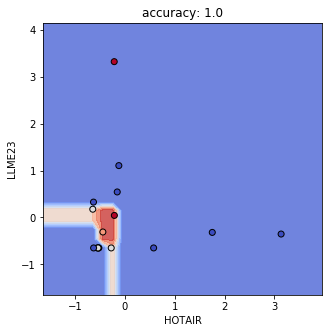

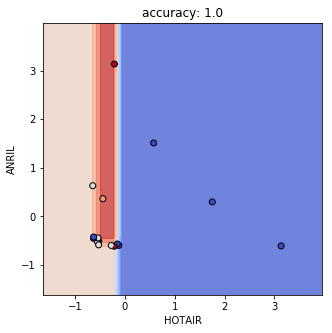

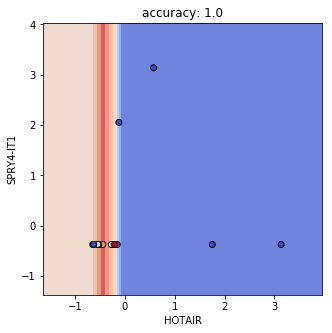

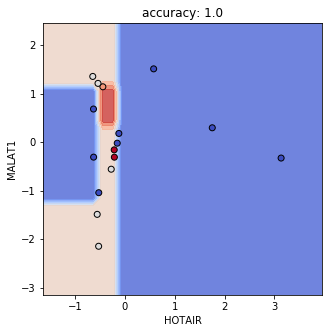

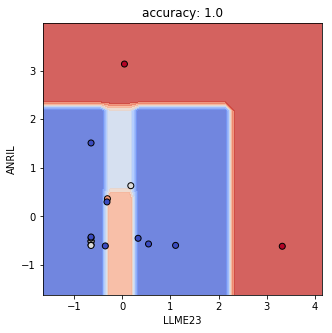

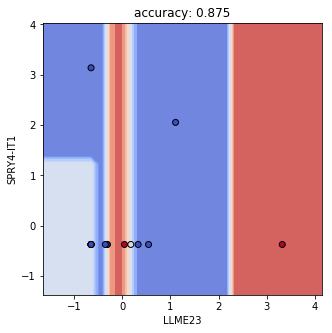

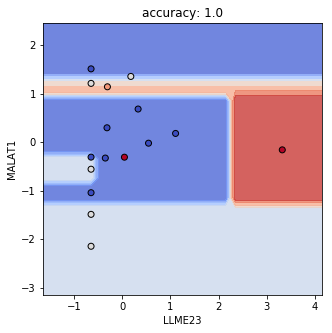

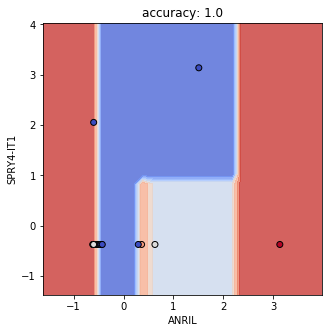

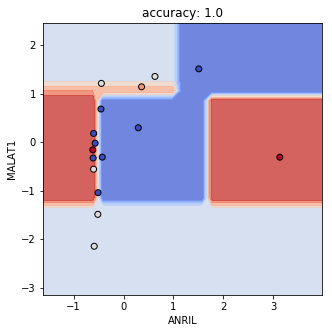

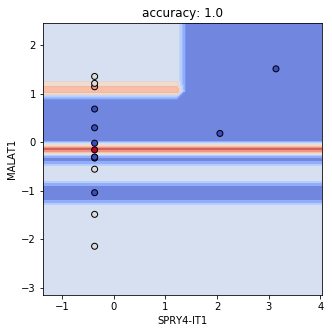

In [213]:
for i, axis in enumerate(features):
    X_sub = X[axis]

    # create a mesh to plot in
    h = 0.2  # step size in the mesh
    x_min, x_max = X_sub[axis[0]].min() - 1, X_sub[axis[0]].max() + 1
    y_min, y_max = X_sub[axis[1]].min() - 1, X_sub[axis[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    plt.figure(figsize=(5,5)) 
#     plt.subplot(6, 6, i+1)
#     plt.subplots_adjust(wspace=0.1, hspace=0.1)

    model.fit(X_sub, y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    accuracy = metrics.accuracy_score(y_pred=np.asanyarray(np.round(model.predict(X_sub)), dtype=int), y_true=y)

    # Plot also the training points
    plt.scatter(X_sub[axis[0]], X_sub[axis[1]], c=y, cmap=plt.cm.coolwarm, edgecolors="black")
    plt.xlabel(axis[0])
    plt.ylabel(axis[1])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
#     plt.xticks(())
#     plt.yticks(())
#     plt.legend(loc='lower left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))
    plt.title("accuracy: "+str(accuracy))
plt.show()

### Importing lncRNA expression and immunotherapy treatment response data from TCGA Skin Cutaneous Melanoma

The long-noncoding RNA expression data was obtained from [TANRIC](http://ibl.mdanderson.org/tanric/_design/basic/index.html), expression of candidate lncRNA biomarkers can be used for numerical analysis. The lncRNA expressions were log2 transformed.

Note, not all TCGA melanoma patients had lncRNA expression profiles or immunotherapy response recorded in the data. So, there were **only 16 samples** that had both lncRNA expression and immunotherapy response data. Another problem with the insufficient sample size is that there are only 2 Complete Response's and 1 Partial Response, for a total of 3 positive immunotherapy response.

In [218]:
X = melanoma_lcrna_immuno_exp.drop(['bcr_patient_barcode', 'SampleID', 'pharmaceutical_therapy_type'], axis=1)
# X = X.applymap(lncRNA_exp_transform) # Log2 transform lncRNA expressions
X

,HOTAIR,MALAT1,UCA1,CASC15,ANRIL,SNHG5,SAMMSON,GAS5,LLME23,RMEL3,SLNCR1,SPRY4-IT1,treatment_best_response
0,0.045786,1.623169,0.000000,2.242216,0.041389,5.909721,0.526308,6.373355,0.000000,0.000000,0.030138,0.000000,Clinical Progressive Disease
1,0.077076,4.023821,0.000000,0.576406,0.365872,5.678011,0.503184,5.237496,0.032775,0.000000,0.012380,0.000000,Partial Response
2,0.912712,3.094637,0.013352,1.767870,0.341291,3.479556,2.160035,5.487785,0.031910,0.000000,0.011792,0.000000,Clinical Progressive Disease
3,0.033865,1.132158,0.000000,1.018009,0.039732,3.058709,0.340364,3.550797,0.000000,0.000000,0.104723,0.000000,Stable Disease
4,1.438499,2.408470,0.000000,1.560618,0.004791,5.295659,1.128106,5.606087,0.028572,0.129702,0.431196,0.000000,Clinical Progressive Disease
5,0.199129,2.966405,0.008589,0.847909,0.008799,4.524830,0.592157,4.995529,0.169247,0.080932,0.009909,0.014017,Clinical Progressive Disease
6,0.464930,4.430245,0.000000,0.081610,0.792343,5.524903,1.305313,6.744909,0.000000,0.005021,0.000562,0.020286,Clinical Progressive Disease
7,0.186805,2.745405,0.000000,1.433710,0.019769,3.209094,1.888804,3.953731,0.115077,2.127053,0.026157,0.000000,Clinical Progressive Disease
8,0.163824,2.594212,0.000000,0.646523,0.002167,4.927034,1.300358,5.129001,0.382899,0.000000,0.000485,0.000000,Complete Response
9,0.044782,0.408822,0.034270,0.196795,0.012896,4.775156,0.028358,4.072337,0.000000,0.000000,0.539940,0.000000,Stable Disease


### Correlation Analysis of each lncRNA to the labels

To perform the correlation analysis, we converted the treament response labels into a numberical scale, following this tumor response criteria:

Complete Response (CR): Disappearance of all target lesions

Partial Response (PR): At least a 30% decrease in the sum of the LD of target lesions, taking as reference the baseline sum LD

Stable Disease (SD): Neither sufficient shrinkage to qualify for PR nor sufficient increase to qualify for PD, taking as reference the smallest sum LD since the treatment started

Progressive Disease (PD): At least a 20% increase in the sum of the LD of target lesions, taking as reference the smallest sum LD recorded since the treatment started or the appearance of one or more new lesions

We made the assignments:
"Clinical Progressive Disease" = -1, 
"Stable Disease" = 0, 
"Partial Response" = 1, 
"Complete Response" = 2, then performed the correlation analysis. 

In [217]:
corr_analysis = pd.DataFrame(columns=["lncRNA", "correlation", "p-value"])
for lncrna in lncrna_list:
    corr, p_val = stats.pearsonr(X[lncrna].as_matrix(), responses)
    corr_analysis.loc[len(corr_analysis)] = (lncrna, corr, p_val)
corr_analysis.sort_values("p-value")

,lncRNA,correlation,p-value
8,LLME23,0.435926,0.091428
4,ANRIL,0.417210,0.107880
11,SPRY4-IT1,-0.297360,0.263357
0,HOTAIR,-0.289931,0.276038
5,SNHG5,0.242986,0.364512
9,RMEL3,-0.172223,0.523601
6,SAMMSON,-0.156797,0.561970
10,SLNCR1,-0.116284,0.668021
7,GAS5,0.088843,0.743521
3,CASC15,-0.088634,0.744106


At the table below, each lncRNA is sorted based on highest absolute-value of Pearson's correlation to the numberized immunotherapy response. Note that LLME23 and ANRIL had the highest correlations at 0.43 and 0.42.